# Refugee resettlement in the USA `13 points`

Source: https://www.refugeeresettlementdata.com/data.html

As described in [Data Is Plural](https://www.data-is-plural.com/archive/2021-07-14-edition/)

> Axel Dreher et al. have published person-level data on 2.5+ million refugees who arrived in the US between 1975 and 2008. The anonymized records, obtained from the National Archives and originally collected by the Office of Refugee Resettlement, indicate each refugee’s country and date of birth, marital and family status, education level and English proficiency, date of US arrival, US city of resettlement, and more. The researchers also combined these records with public reports from the Bureau of Population, Refugees, and Migration (DIP 2015.11.25) to create a geocoded dataset of annual resettlements by citizenship and destination city from 1975 to 2018.

### Topics covered

* Aggregating
* Filtering
* Unfriendly complexity in data
* Exploratory visualization
* FIPS codes
* Mapping

# Basic analysis `4 points`

### Read in your data

We'll be using the geocoded file, which comes as a `dta` file. A `.dta` file is technically an export from [STATA](https://www.stata.com/), which means you use `pd.read_stata` to bring it in – but otherwise it's the same as a CSV.

In [101]:
import pandas as pd
df=pd.read_stata("orr_prm_1975_2018_v1.dta")

In [2]:
df.sample(5)

,city_id,city_nat_id,city_nat_year_id,year,citizenship_stable,refugees,city,city_code,county_fips,state_fips,fips,county10name,countyfp10,statefp10,geo_level,longitude,latitude,id_merging
7054,606.0,1918.0,6902.0,1997,yugoslavia,14.0,Alameda,562.0,001,06,06001,Alameda,001,06,city,-122.264778,37.770561,5831.0
111823,11867.0,34934.0,111026.0,2003,afghanistan,7.0,Hampton,35000.0,650,51,51650,Hampton,650,51,city,-76.389923,37.072659,89415.0
65182,6669.0,19291.0,64584.0,1978,vietnam,4.0,Barrington,3844.0,097,17,17097,Cook,031,17,city,-88.136189,42.153914,52799.0
11258,835.0,2955.0,11038.0,1998,iran,4.0,Dublin,20018.0,001,06,06001,Alameda,001,06,city,-121.906326,37.714401,9350.0
75009,7767.0,22576.0,74368.0,1979,laos,4.0,Auburn,3076.0,081,01,01081,Lee,081,01,city,-85.468224,32.547543,60508.0


In [14]:
df.keys()

Index(['city_id', 'city_nat_id', 'city_nat_year_id', 'year',
       'citizenship_stable', 'refugees', 'city', 'city_code', 'county_fips',
       'state_fips', 'fips', 'county10name', 'countyfp10', 'statefp10',
       'geo_level', 'longitude', 'latitude', 'id_merging'],
      dtype='object')

### What years does this dataset include?

In [11]:
df.year.min()

1975

In [12]:
df.year.max()

2018

It includes the years 1975 until 2018.

### According to this dataset, what are the top 5 countries for refugees resettled into the United States?

In [21]:
df.groupby(["citizenship_stable"]).refugees.sum().sort_values(ascending=False).head(5)

citizenship_stable
vietnam       816540.0
ussr          506997.0
laos          244136.0
iraq          177425.0
yugoslavia    167711.0
Name: refugees, dtype: float32

### Why can't I use `.value_counts()` to tell me how many refugees came from each country?

Because they have an extra column called refugees, that describe how many refugees came, and value counts would just count the rows.

### What are the top 5 cities for resettling refugees?

In [22]:
df.groupby(["city"]).refugees.sum().sort_values(ascending=False).head(5)

city
Brooklyn       94611.0
Los Angeles    87116.0
Houston        72119.0
Chicago        67413.0
San Diego      58238.0
Name: refugees, dtype: float32

### Surprise, you got tricked! You can't just use `city` to answer that question. Why?

It will help if you try to look at all of the rows for the city of Brooklyn.

In [31]:
df[df.city=="Brooklyn"]

# there are some some cities with the same name but in different counties!!

,city_id,city_nat_id,city_nat_year_id,year,citizenship_stable,refugees,city,city_code,county_fips,state_fips,fips,county10name,countyfp10,statefp10,geo_level,longitude,latitude,id_merging
56400,5139.0,16074.0,55809.0,1999,ethiopia,11.0,Brooklyn,7930.0,137,27,27137,St. Louis,137,27,city,-92.921021,47.439654,45388.0
56401,5139.0,16074.0,55810.0,2000,ethiopia,4.0,Brooklyn,7930.0,137,27,27137,St. Louis,137,27,city,-92.921021,47.439654,45389.0
56402,5139.0,16074.0,55811.0,2004,ethiopia,10.0,Brooklyn,7930.0,137,27,27137,St. Louis,137,27,city,-92.921021,47.439654,45390.0
56403,5139.0,16075.0,55812.0,1983,laos,7.0,Brooklyn,7930.0,137,27,27137,St. Louis,137,27,city,-92.921021,47.439654,45391.0
56404,5139.0,16075.0,55813.0,2005,laos,2.0,Brooklyn,7930.0,137,27,27137,St. Louis,137,27,city,-92.921021,47.439654,45392.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137130,14857.0,44199.0,136177.0,1986,iran,1.0,Brooklyn,9210.0,021,25,25021,Norfolk,021,25,city,-71.110893,42.335499,111229.0
137131,14857.0,44200.0,136178.0,1988,ussr,5.0,Brooklyn,9210.0,021,25,25021,Norfolk,021,25,city,-71.110893,42.335499,111230.0
137132,14857.0,44201.0,136179.0,1978,vietnam,1.0,Brooklyn,9210.0,021,25,25021,Norfolk,021,25,city,-71.110893,42.335499,111231.0
137133,14857.0,44201.0,136180.0,1980,vietnam,1.0,Brooklyn,9210.0,021,25,25021,Norfolk,021,25,city,-71.110893,42.335499,111232.0


### What is the correct answer for the top 5 cities for resettling refugees?

Spoiler: I recommend using both `city` *and* `city_id` every time you want to look at individual cities. Also: it might be the same answer, but the numbers will be a little different.

In [32]:
df.groupby(["city","city_id"]).refugees.sum().sort_values(ascending=False).head(5)

city         city_id
Brooklyn     13433.0    94096.0
Los Angeles  1609.0     84202.0
Chicago      7094.0     56712.0
Houston      4198.0     54324.0
San Diego    2046.0     45724.0
Name: refugees, dtype: float32

### Comparing cities

Pick 3 cities in the United States - one on the east coast, one on the west coast, and one somewhere in between. What are the top 10 countries for refugees for each? Be sure to use `city_id`.

In [47]:
# West Coast: Brooklyn

df[(df.city_id==13433.0)].groupby("citizenship_stable").refugees.sum().sort_values(ascending=False).head(5)

citizenship_stable
ussr          85138.0
vietnam        2573.0
yugoslavia     1178.0
cambodia       1094.0
iran            898.0
Name: refugees, dtype: float32

In [48]:
# East Coast: Los Angeles

df[(df.city_id==1609.0)].groupby("citizenship_stable").refugees.sum().sort_values(ascending=False).head(5)

citizenship_stable
vietnam     39800.0
ussr        22250.0
iran         6668.0
cambodia     6461.0
laos         4111.0
Name: refugees, dtype: float32

In [49]:
# Middle: Houston


df[(df.city_id==4198.0)].groupby("citizenship_stable").refugees.sum().sort_values(ascending=False).head(5)

citizenship_stable
vietnam       29254.0
cambodia       4965.0
yugoslavia     3281.0
laos           2481.0
somalia        2129.0
Name: refugees, dtype: float32

### Where were refugees from Afghanistan resettled before 2000 as compared to after 2000?

In [62]:
df[(df.year<2000)&(df.citizenship_stable=="afghanistan")].groupby("city").refugees.sum().sort_values(ascending=False).head(5)

city
Hayward        1101.0
Flushing        959.0
Alexandria      836.0
Fremont         557.0
Los Angeles     546.0
Name: refugees, dtype: float32

In [63]:
df[(df.year>2000)&(df.citizenship_stable=="afghanistan")].groupby("city").refugees.sum().sort_values(ascending=False).head(5)

city
Phoenix       1079.0
San Diego      720.0
Houston        639.0
Boise City     527.0
Sacramento     520.0
Name: refugees, dtype: float32

### Exploratory line charts `1 point`

**Using line charts,** examine 3 different countries' patterns of entry into the US over the years. What do their entry trends look like over time?

In [126]:
# creating a subset of the data with 3 countries and sum up the refugees number by year and citizenship

df_subset=df[df.citizenship_stable.isin(["afghanistan","vietnam","iraq"])].groupby(["year","citizenship_stable"]).refugees.sum().reset_index()
df_subset = pd.DataFrame(df_subset)

# create a multiple line chart using altair

import altair as alt


alt.Chart(df_subset).mark_line().encode(
    x='year',
    y='refugees',
    color='citizenship_stable',
    strokeDash='citizenship_stable',
)


alt.Chart(...)

### DataWrapper charts with annotations `2 points`

Using [DataWrapper](https://www.datawrapper.de/), make a line chart of one of the countries' refugees inflow over the years. **Use the annotation tool to note event(s) that caused an influx of refugees.**

Link the chart in the cell below.

In [129]:
# subset the data for vietnam only

df_vietnam=df[df.citizenship_stable.isin(["vietnam"])].groupby(["year","citizenship_stable"]).refugees.sum().reset_index()
df_vietnam = pd.DataFrame(df_vietnam)

#save to csv, need the filename!!
df_vietnam.to_csv(r'vietnam.csv', index = False, header=True)


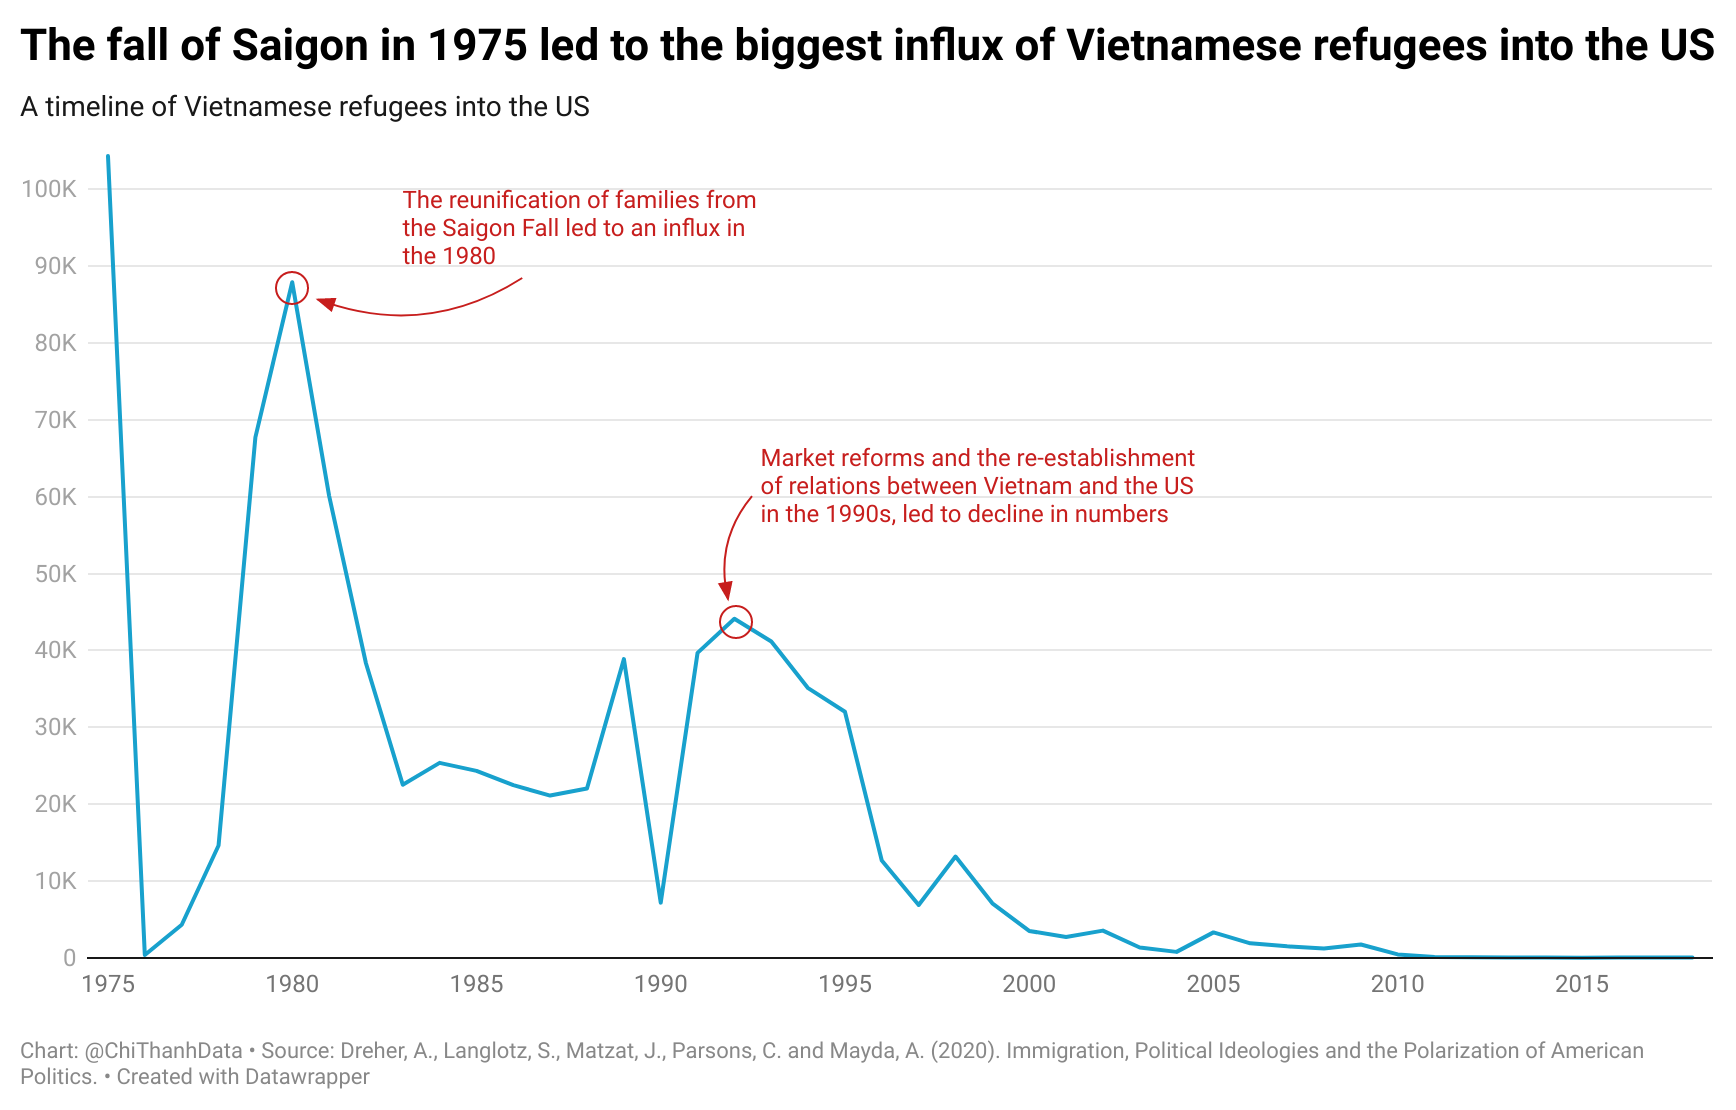

### What are the top seven states for refugee resettlement in the USA? `1 point`

Trying to use a CSV of FIPS codes and state names never works out well, I recommend doing cleaning that up manually.

### Mapping refugees, level 1 `2 point`

Make a state-based choropleth of where refugees from a given country (your choice) have been resettled in the USA.

Use the tool of your choice: DataWrapper, MapShaper, or QGIS.

### Mapping refugees, level 2 `3 points`

Make an animated map or a grid of maps of where refugees from a given country have been resettled in the USA.

Use the tool of your choice: DataWrapper, MapShaper, or QGIS.

> **Tip:** Depending on the tool you use, you might want either long or wide data. Using `.reset_index()` will give you long data, `.unstack()` will give you wide data.